<a href="https://colab.research.google.com/github/yehezkielgunawan/tugas-business-intelligence/blob/main/tugas_business_intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset & Install Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import os
import warnings
!pip install bert-tensorflow
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Verbosity is now 5

tf.autograph.set_verbosity(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df1 = pd.read_csv('/content/gdrive/My Drive/Tugas Business Intelligence/Reviews.csv')
df1.head(5)
df1.head(5).to_json()

'{"Id":{"0":1,"1":2,"2":3,"3":4,"4":5},"ProductId":{"0":"B001E4KFG0","1":"B00813GRG4","2":"B000LQOCH0","3":"B000UA0QIQ","4":"B006K2ZZ7K"},"UserId":{"0":"A3SGXH7AUHU8GW","1":"A1D87F6ZCVE5NK","2":"ABXLMWJIXXAIN","3":"A395BORC6FGVXV","4":"A1UQRSCLF8GW1T"},"ProfileName":{"0":"delmartian","1":"dll pa","2":"Natalia Corres \\"Natalia Corres\\"","3":"Karl","4":"Michael D. Bigham \\"M. Wassir\\""},"HelpfulnessNumerator":{"0":1,"1":0,"2":1,"3":3,"4":0},"HelpfulnessDenominator":{"0":1,"1":0,"2":1,"3":3,"4":0},"Score":{"0":5,"1":1,"2":4,"3":2,"4":5},"Time":{"0":1303862400,"1":1346976000,"2":1219017600,"3":1307923200,"4":1350777600},"Summary":{"0":"Good Quality Dog Food","1":"Not as Advertised","2":"\\"Delight\\" says it all","3":"Cough Medicine","4":"Great taffy"},"Text":{"0":"I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appr

# Preprocessing Data

In [ ]:
df1.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## We only use Text, and Score column for classification purpose

In [ ]:
all_cols = df1.columns
keep_cols = ['Score', 'Text']
df1.drop([c for c in all_cols if c not in keep_cols], axis=1, inplace=True)
df1.head(10)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
5,4,I got a wild hair for taffy and ordered this f...
6,5,This saltwater taffy had great flavors and was...
7,5,This taffy is so good. It is very soft and ch...
8,5,Right now I'm mostly just sprouting this so my...
9,5,This is a very healthy dog food. Good for thei...


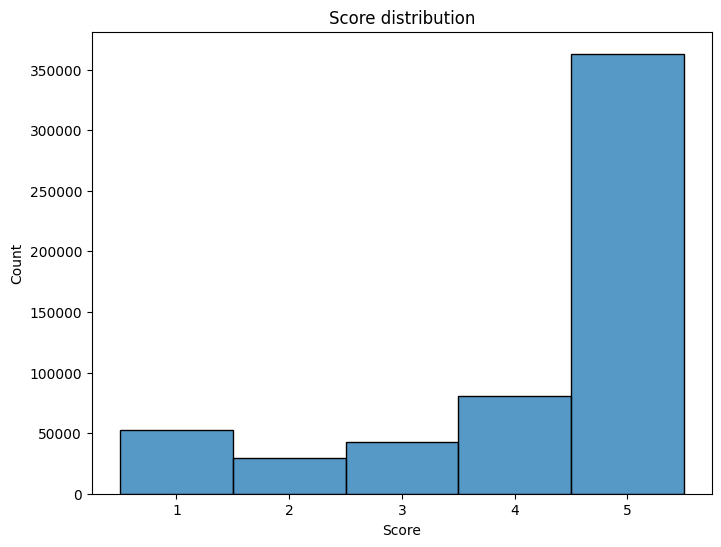

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('Score distribution')
sns.histplot(df1['Score'], discrete=True);

## Take just 10k row data as sample, too much data takes more time to be trained

In [ ]:
df1 = df1.sample(n=10000, random_state=30)

In [ ]:
import re
df1['Text']=df1['Text'].apply(lambda row : re.sub('<.*?>','',row))

We are doing sentiment analysis hence we will convert label to 0 or 1¶
0: Negative Review
1: Positive Review

In [ ]:
df1.loc[df1['Score'] <=2, 'Score'] = 0
df1.loc[df1['Score'] > 3, 'Score'] = 1

In [ ]:
df1.drop(df1[df1['Score']==3].index,inplace=True)

In [ ]:
df1['len'] = df1.Text.apply(lambda x: len(x.split()))

In [ ]:
df1 = df1[df1.len<50]

# Train Test Split the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1[['Text','len']],df1.Score, test_size=0.2, random_state=42, stratify=df1.Score)

In [ ]:
X_train.shape,X_test.shape

((3321, 2), (831, 2))

# Classification using BERT

In [ ]:
max_seq_length = 55
tf.keras.backend.clear_session()
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
                # ids of words
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
                # masking of ids
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
                # segment of ids
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
def bert_preprocess(sentence,tokenizer,max_seq_len=512):
    tokens=[]
    masks=[]
    segments=[]
    for word in sentence:
        word=tokenizer.tokenize(word)
        word=word[:max_seq_len-2]
        seq=["[CLS]"] + word + ["[SEP]"]
        token = tokenizer.convert_tokens_to_ids(seq)
        padding_tokens=token+[0]*(max_seq_len-len(token))
        mask=[1]*len(seq)
        masking=mask+[0]*(max_seq_len-len(token))
        segment=np.zeros(max_seq_length)
        
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens),np.array(masks),np.array(segments)

In [ ]:
from bert import tokenization
tokenizer =tokenization.FullTokenizer(vocab_file,do_lower_case)

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,55)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,55)

In [ ]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

26/26 [==============================] - 177s 7s/step


In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

import datetime
from sklearn.metrics import roc_auc_score

In [ ]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_test)
        auc.append(auc_tr)
        val_auc.append(auc_test)
        loss=logs.get('loss')

In [ ]:
#Callbacks
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

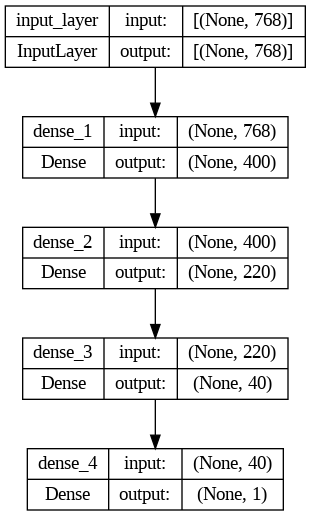

In [ ]:
##create an NN and 
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

In [ ]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [ ]:
X_test_pooled_output.shape

(831, 768)

In [ ]:
!rm -rf ./logs_model1/ 
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[history_own])

Epoch 1/50
26/26 [==============================] - 0s 3ms/step

  train_auc :  0.8065007234509405
  val_auc :  0.7579099850059721
104/104 [==============================] - 3s 19ms/step - loss: 0.3906 - accuracy: 0.8636 - val_loss: 0.3612 - val_accuracy: 0.8688
Epoch 2/50
26/26 [==============================] - 0s 3ms/step

  train_auc :  0.8591250218625284
  val_auc :  0.8144806729522986
104/104 [==============================] - 2s 16ms/step - loss: 0.3419 - accuracy: 0.8675 - val_loss: 0.3240 - val_accuracy: 0.8688
Epoch 3/50
26/26 [==============================] - 0s 3ms/step

  train_auc :  0.8960273798355938
  val_auc :  0.8622074258558032
104/104 [==============================] - 1s 14ms/step - loss: 0.3157 - accuracy: 0.8729 - val_loss: 0.2923 - val_accuracy: 0.8664
Epoch 4/50
26/26 [==============================] - 0s 5ms/step

  train_auc :  0.9183589588666464
  val_auc :  0.8816488347861446
104/104 [==============================] - 2s 22ms/step - loss: 0.2876 - accurac

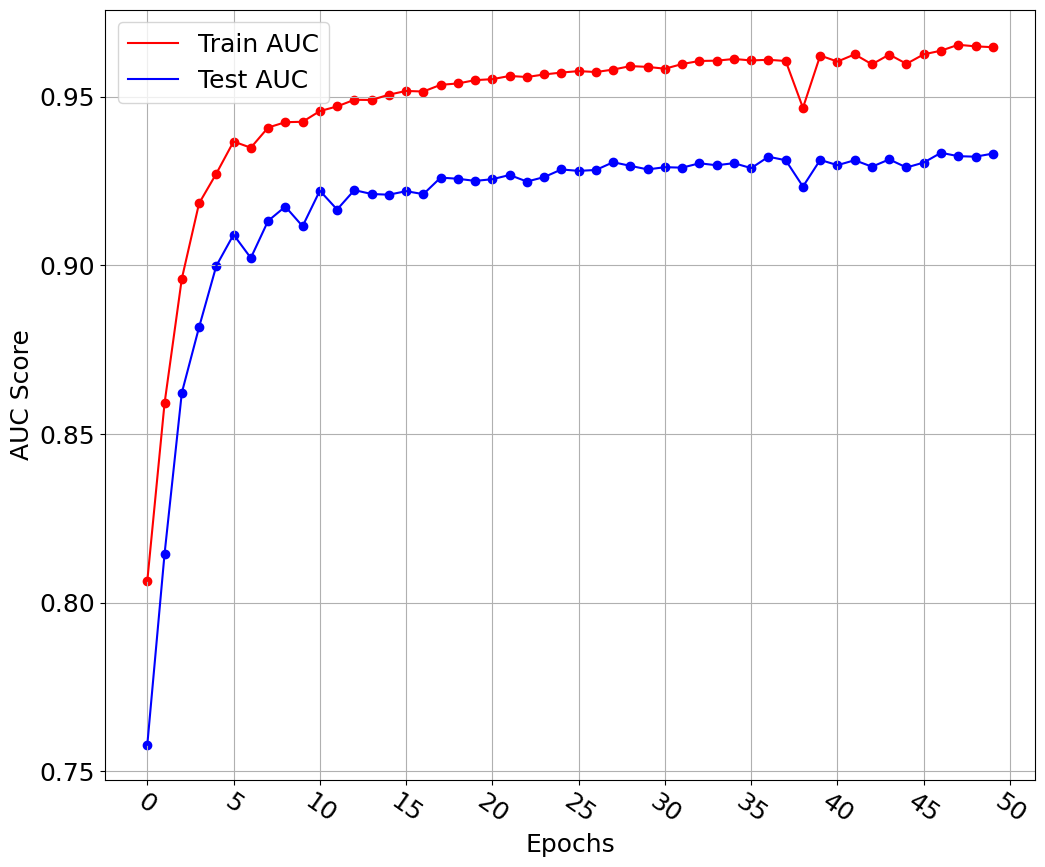

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.plot(np.arange(len(auc)),auc,color="red")
plt.plot(np.arange(len(auc)),val_auc,color='blue')
plt.scatter(np.arange(len(auc)),auc,color='red')
plt.scatter(np.arange(len(auc)),val_auc,color='blue')
plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Test AUC'])
plt.grid()
plt.show()

In [ ]:
# Get predicted labels for test data
y_pred = model1.predict(X_test_pooled_output)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

26/26 [==============================] - 0s 3ms/step
Confusion Matrix:
[[ 67  42]
 [ 26 696]]


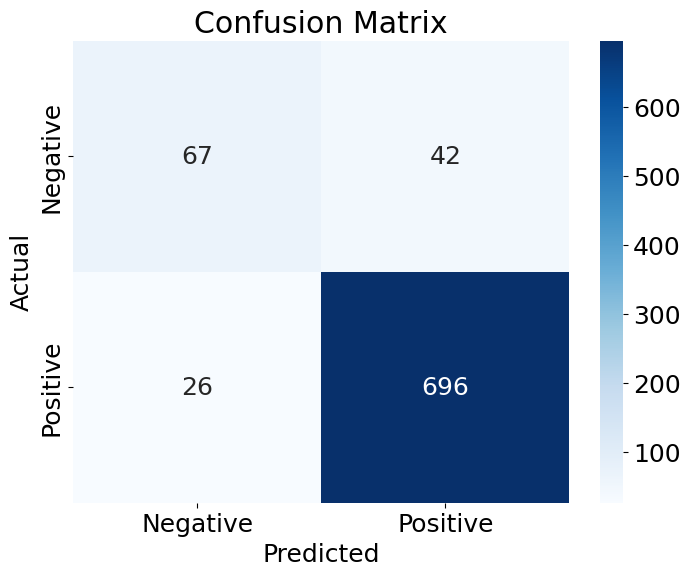

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create labels for the confusion matrix
labels = ['Negative', 'Positive']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [36]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

# Calculate metrics
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)


Precision: 0.943089430894309
Accuracy: 0.9181708784596871
F1-score: 0.9534246575342467
Recall: 0.96398891966759
